# Salmon-lamprey-pinniped dynamics

Below is a simplified representation of a three species dynamical system involving two anadromous fish species that spend part of their lifecycle in freshwater (rivers) and part of their lifecycle in the ocean.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

For both lamprey and salmon, their lifecycle is as follows:
1. In freshwater, **spawners** (adults) lay eggs and produce recruits (babies). The relationship between the number of spawners and number of recruits they produce is known as a stock-recruit relationship. This relationship is density-dependent.
2. The recruits leave freshwater as **smolts** and exit the dams to reach the ocean and eat.
3. The smolts **return** back to the estuary to become spawners again, where they encounter pinnipeds in the estuary and at the entrance of the dam.
4. Before making their way back to their spawning sites to lay eggs, the spawners (adults) face mortality in freshwater from dams, pollution, etc.

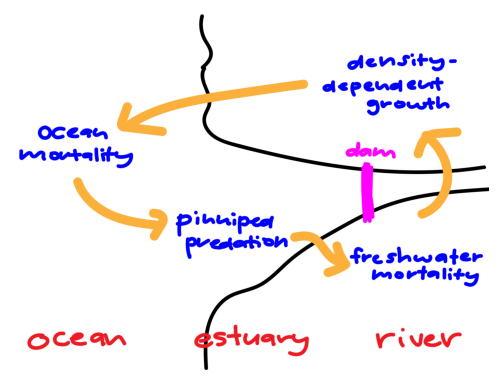

In [2]:
img = mpimg.imread("img/dynamics_diagram-01.png")
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

For pinnipeds (harbor seals, California sea lions, Steller sea lions), their life cycle is slightly different. Their breeding grounds are far away from the river system, and during the non-breeding portion of the year, some male pinnipeds travel to the river system to predate on fish.
1. Density-dependent population growth in breeding grounds.
2. A portion of male pinnipeds migrate to the estuary to predate on salmon.
3. Male pinnipeds return to breeding grounds.

### Inter-species dynamics

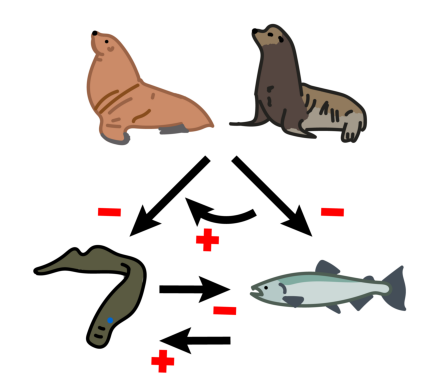

In [4]:
img = mpimg.imread("img/foodweb-01.png")
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

All three species are undergoing their own population growth and mortality, but they can also directly and indirectly affect the dynamics of other species. For example:
1. Pinnipeds reduce the population sizes of lamprey and salmon returns in the estuary through predation.
2. Lamprey returns indirectly reduce pinniped predation pressure on salmon returns because they are a higher-value prey item.
3. Lamprey are parasites, and salmon increase lamprey ocean survival, yet simultaneously lamprey decrease salmon ocean survival.

### Equations of the dynamical system

**First are the state variables:**

$P_t$ = abundance of pinnipeds in time t

$L_{spawners,t}$ = abundance of lamprey spawners in time t

$L_{smolts,t}$ = abundance of lamprey smolts in time t

$L_{returns,t}$ = abundance of lamprey returns in time t

$S_{spawners,t}$ = abundance of salmon spawners in time t

$S_{smolts,t}$ = abundance of salmon smolts in time t

$S_{returns,t}$ = abundance of salmon returns in time t

**Next are the growth equations of all species:**

$L_{smolts,t} = L_{spawners,t} + L_{spawners,t} \times r_L \times (1-\frac{L_{spawners,t}}{K_L}) + \sigma_{G,L}$

$S_{smolts,t} = S_{spawners,t} + S_{spawners,t} \times r_S \times (1-\frac{S_{spawners,t}}{K_S}) + \sigma_{G,S}$

$P_{t+1} = P_t + P_t \times r_P \times (1-(\frac{P_t}{K_P})^{z_P}) + \sigma_{G,P}$

**Now the ocean survival of lamprey and salmon:**

$L_{returns,t} = L_{smolts,t} \times (1 - e^{-d_L*S_{smolts,t}}) \times s_{ocean}$

$S_{returns,t} = S_{smolts,t} \times (1 - e^{\frac{-d_S}{L_{smolts,t}}}) \times s_{ocean}$

**Finally pinniped predation in the estuary:**

Abundance of pinnipeds entering the estuary:

$P_{estuary} = P_t \times p_{travel} \times p_{males}$

Per pinniped predation rate:

$L_{prey,t} = \frac{C_L \times L_{returns,t}^{m_L}}{P_{estuary}^{b}+ h (C_L \times L_{returns,t}^{m_L} + C_S \times S_{returns,t}^{m_S})}$

$S_{prey,t} = \frac{C_S \times S_{returns,t}^{m_S}}{P_{estuary}^{b}+ h (C_L \times L_{returns,t}^{m_L} + C_S \times S_{returns,t}^{m_S})}$

Transition from returns to spawners in t+1:

$L_{spawners, t+1} = (L_{returns,t} - L_{prey,t} \times P_{estuary}) \times s_{L,river}$

$S_{spawners, t+1} = (S_{returns,t} - S_{prey,t} \times P_{estuary}) \times s_{S,river}$


In [52]:
# get parameters
params = {
    "growth_L_r": 0.6, # lamprey intrinsic rate of growth
    "growth_L_K": 1000000, # lamprey carrying capacity
    "growth_S_r": 0.4, # salmon intrinsic rate of growth
    "growth_S_K": 1000000, # salmon carrying capacity
    "growth_P_r": 0.06, # pinniped intrinsic rate of growth
    "growth_P_K": 275298, # pinniped carrying capacity
    "growth_P_z": 3.93, # pinniped growth exponent
    "growth_sd_f": 50000, # variation in fish population growth
    "growth_sd_p": 10000, # variation in pinniped population growth
    "ocean_dd_L": 0.00001, # lamprey ocean survival (function of salmon density)
    "ocean_dd_S": 3000000, # salmon ocean survival (function of lamprey density)
    "ocean_surv1": 15, # beta dist. parameter for shared density-independent ocean survival
    "ocean_surv2": 1, # beta dist. parameter for shared density-independent ocean survival
    "p_male": 0.4, # proportion of pinnipeds that are males
    "p_travel": 0.02, # probability that pinniped males travel to the river to eat
    "pred_m": [1, 1], # prey switching exponents [lamprey, salmon], 1 = no switching
    "pred_c": [0.1, 0.03], # prey attack rate [lamprey, salmon]
    "pred_b": 0.3, # strength of predator density-dependence
    "pred_h": 0.1, # predator handling time
    "mortality": [0.3, 0.1] # river spawner mortality [lamprey, salmon]
} 

### density-dependent growth

In [20]:
# density dependent growth
def growth_fish(params, L, S):
    
    # logistic growth
    Lplus = (
        L + L * params["growth_L_r"] * (1 - L / params["growth_L_K"]) + 
        np.random.normal(0, params["growth_sd_f"]) # growth error
    )
        
    Splus = (
        S + S * params["growth_S_r"] * (1 - S / params["growth_S_K"]) +
        np.random.normal(0, params["growth_sd_f"]) # growth error
    )
    
    return [max(Lplus, 0), max(Splus, 0)]

def growth_pin(params, P):

    Pplus = (
        P + P * params["growth_P_r"] * (1 - (P / params["growth_P_K"])**params["growth_P_z"]) +
        np.random.normal(0, params["growth_sd_p"]) # growth error
    )
    
    return max(Pplus, 0)

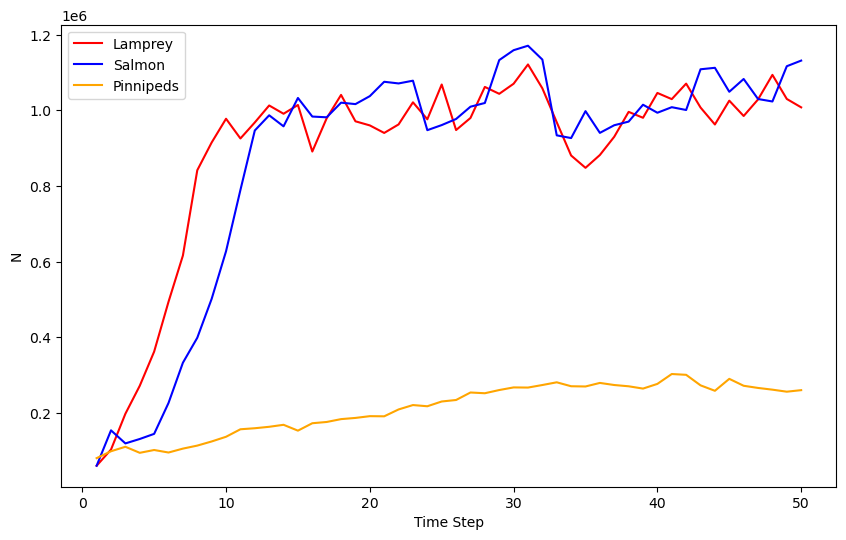

In [21]:
# plot

# create df
df = pd.DataFrame(np.nan, index=range(50), columns=['L', 'S', 'P'])

# Set initial values for the first row
df.iloc[0] = [60000, 60000, 80000]

# growth
for i in range(1, len(df)):
    smolts = growth_fish(params, df.iloc[i-1, 0], df.iloc[i-1, 1])
    Pplus = growth_pin(params, df.iloc[i-1, 2]) 
    df.iloc[i, 0] = smolts[0] 
    df.iloc[i, 1] = smolts[1] 
    df.iloc[i, 2] = Pplus 

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), df['L'], color='red', label='Lamprey')
plt.plot(range(1, 51), df['S'], color='blue', label='Salmon')
plt.plot(range(1, 51), df['P'], color='orange', label='Pinnipeds')
plt.xlabel('Time Step')
plt.ylabel('N')
plt.legend()
plt.show()

### ocean survival

In [6]:
# ocean survival
def ocean(params, L, S):
    # get ocean survival
    surv = np.random.beta(params["ocean_surv1"], params["ocean_surv2"])
    
    # L and S density-dependent survival interaction
    Lplus = L * (1 - np.exp(-params["ocean_dd_L"] * (S+1e-6))) * surv
    Splus = S * (1 - np.exp(-params["ocean_dd_S"] / (L+1e-6))) * surv
    
    return [Lplus, Splus]

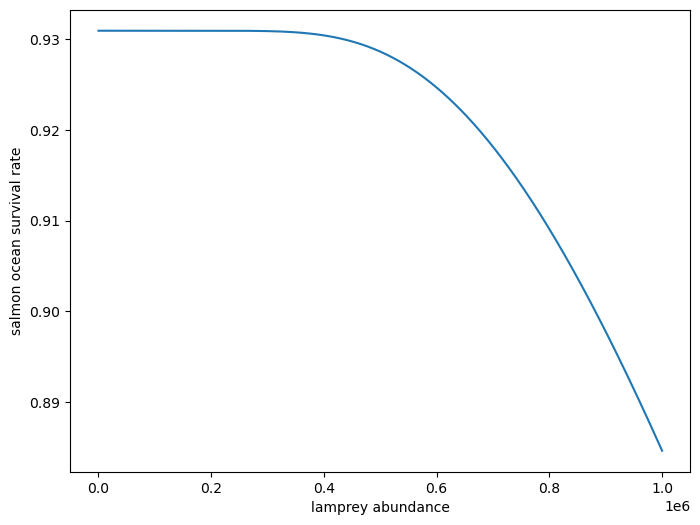

In [7]:
# salmon ocean survival as a function of lamprey abundance

# generate a density-indendent survival rate from a beta distribution
surv = np.random.beta(params["ocean_surv1"], params["ocean_surv2"])

# lamprey density
L = np.arange(1, params["growth_L_K"] + 1, 100)

# get overall salmon survival rate
y = (1 - np.exp(-params["ocean_dd_S"] / L)) * surv

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(L, y)
plt.xlabel("lamprey abundance")
plt.ylabel("salmon ocean survival rate")
plt.show()

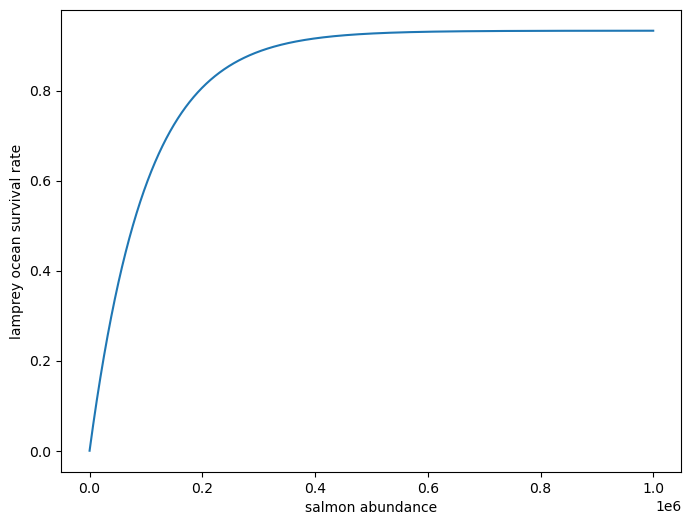

In [8]:
# lamprey ocean survival as a function of salmon abundance

# generate a density-indendent survival rate from a beta distribution
surv = np.random.beta(params["ocean_surv1"], params["ocean_surv2"])

# salmon density
S = np.arange(1, params["growth_S_K"] + 1, 100)

# get overall salmon survival rate
y = (1 - np.exp(-params["ocean_dd_L"] * S)) * surv

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(L, y)
plt.xlabel("salmon abundance")
plt.ylabel("lamprey ocean survival rate")
plt.show()

### estuary predation

In [53]:
# estuary predation 
def predation(params, L, S, P):
    x = np.array([L, S])
    
    # Calculate the denominator
    denominator = (
        P ** params["pred_b"] + params["pred_h"] * np.sum(params["pred_c"] * x ** params["pred_m"])
    )
    
    # get L and S prey per predator
    L_prey = params["pred_c"][0] * L ** params["pred_m"][0] / denominator
    S_prey = params["pred_c"][1] * S ** params["pred_m"][1] / denominator
    
    return [L_prey, S_prey]

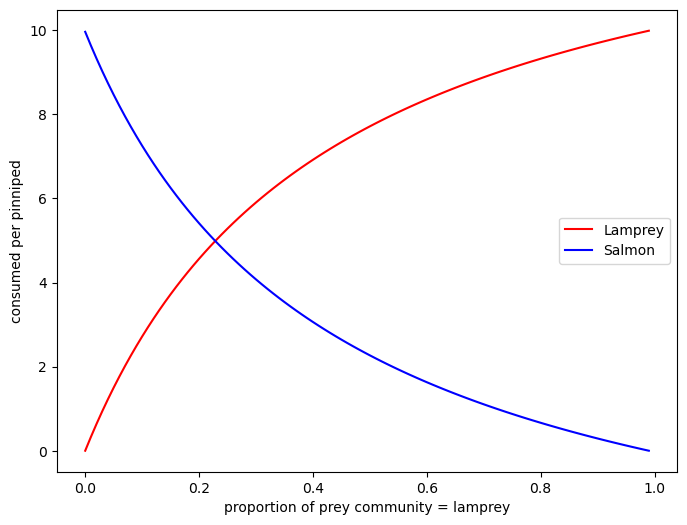

In [74]:
# per pinniped predation rate

total = 500000

# get number of prey based on proportion of total of each fish
df = pd.DataFrame(columns=['L_prop', 'S_prop', 'L_prey','S_prey'])
df['L_prop'] = np.arange(0, 1, 0.01)
df['S_prop'] = np.arange(0, 1, 0.01)[::-1]

for index, row in df.iterrows():
    # get prey per pinniped
    prey = predation(params, L = row['L_prop']*total, 
                     S = row['S_prop']*total, P = 300)
    
    # add to df
    df.at[index, 'L_prey'] = prey[0]
    df.at[index, 'S_prey'] = prey[1]

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 1, 0.01), 
         df['L_prey'], color='red', label='Lamprey')
plt.plot(np.arange(0, 1, 0.01), 
         df['S_prey'], color='blue', label='Salmon')
plt.xlabel("proportion of prey community = lamprey")
plt.ylabel("consumed per pinniped")
plt.legend()
plt.show()

### combine everything!

In [22]:
# add an action space
A = [
    0, # lamprey spawner mortality reduction
    0 # pinniped harvest
]

In [23]:
# full step function
def step(params, L, S, P, action):
       
    # density-dependent reproduction
    smolts = growth_fish(params, L, S)
    Pplus = growth_pin(params, P)
    
    # ocean mortality
    returns = ocean(params, smolts[0], smolts[1])
    
    # get number of pinnipeds in estuary (males that traveled - harvest)
    P_estuary = (
        np.random.binomial(n=round(Pplus*params["p_male"]), p = params["p_travel"])-
        action[1]
    )
    P_estuary = max(0, P_estuary)
    Pplus -= action[1] # update Pplus

    # get consumed prey per predator
    consumed = np.array(predation(params, returns[0], returns[1], P_estuary)) * P_estuary

    # get final numbers of spawners to system
    spawners_L = returns[0] - consumed[0]
    spawners_S = returns[1] - consumed[1]

    # Spawner mortality
    L_mort = max(0, params["mortality"][0] - action[0]) # altered lamprey survival
    Lplus = np.random.binomial(n=round(spawners_L), p = 1 - L_mort)
    Splus = np.random.binomial(n=round(spawners_S), p = 1 - params["mortality"][1])
    
    # Return the final spawner and pinniped values
    return [Lplus, Splus, Pplus]

In [41]:
# iterate
# create empty df
df = pd.DataFrame(np.nan, index=range(50), columns=['L', 'S', 'P'])

# set initial values for the first row
df.iloc[0] = [
    60000, # lamprey
    500000, # salmon
    100000 # pinnipeds
]

# Loop to populate the df using the step function
for i in range(1, len(df)):
    df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2] = step(params, df.iloc[i-1, 0], 
                                                       df.iloc[i-1, 1], df.iloc[i-1, 2],A)

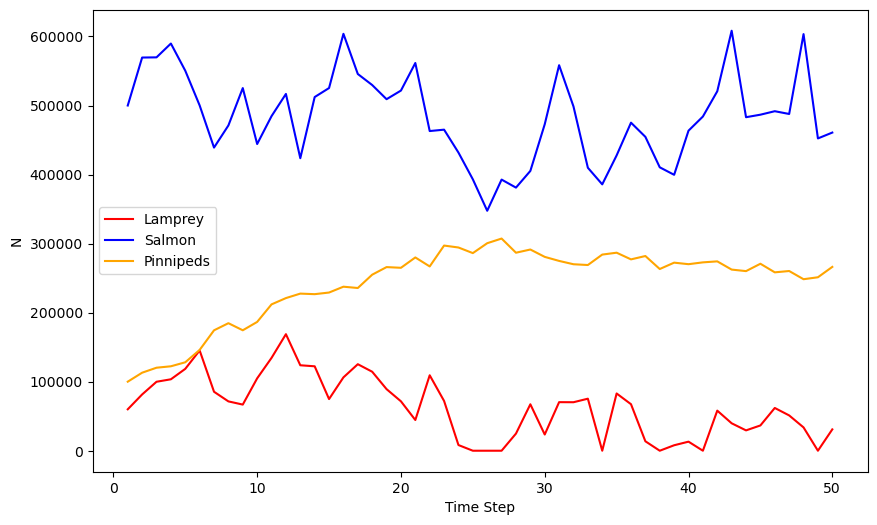

In [42]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), df['L'], color='red', label='Lamprey')
plt.plot(range(1, 51), df['S'], color='blue', label='Salmon')
plt.plot(range(1, 51), df['P'], color='orange', label='Pinnipeds')
plt.xlabel('Time Step')
plt.ylabel('N')
plt.legend()
plt.show()

In [43]:
# now decrease lamprey mortality
A = [
    0.1, # lamprey spawner mortality reduction
    0 # pinniped harvest rate
]

df = pd.DataFrame(np.nan, index=range(50), columns=['L', 'S', 'P'])

# set initial values for the first row
df.iloc[0] = [
    60000, # lamprey
    500000, # salmon
    100000 # pinnipeds
]

# Loop to populate the df using the step function
for i in range(1, len(df)):
    df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2] = step(params, df.iloc[i-1, 0], 
                                                       df.iloc[i-1, 1], df.iloc[i-1, 2],A)

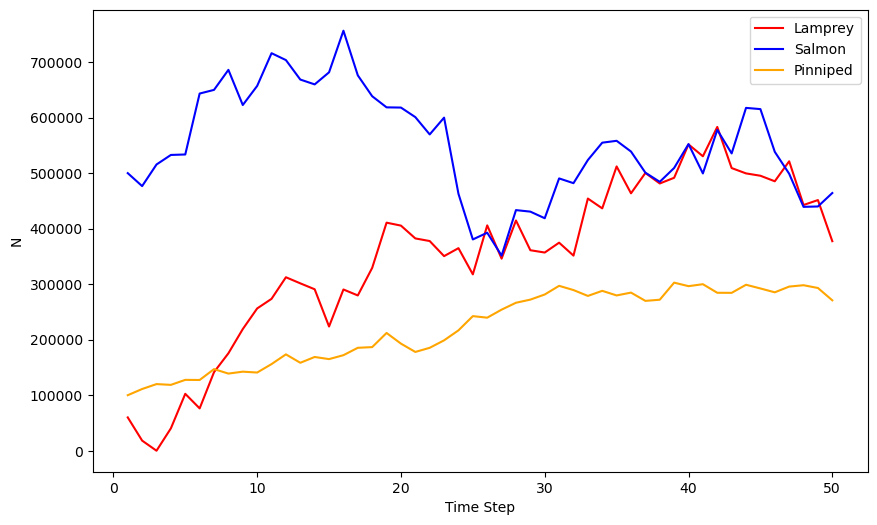

In [44]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), df['L'], color='red', label='Lamprey')
plt.plot(range(1, 51), df['S'], color='blue', label='Salmon')
plt.plot(range(1, 51), df['P'], color='orange', label='Pinniped')
plt.xlabel('Time Step')
plt.ylabel('N')
plt.legend()
plt.show()